In this post I will use the NBA API to access shot chart data and use it to make some cool plots based on the shot zone infromation which is available in the raw data. 

I wrote a package in order to access the NBA api. It can be see on my github page (https://github.com/eyalshafran/NBAapi). 
This NBA package also includes some plotting features as I will show in this post. This package is an on going project which will be updated as I keep working on this blog.

In [1]:
import NBAapi as nba
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import sys
from scipy import misc
from scipy.stats.stats import pearsonr
%matplotlib inline 

First let's access the data and preview it:

In [2]:
shotchart,leagueavergae = nba.shotchart.shotchartdetail(season='2016-17') # get shot chart data from NBA.stats
shotchart.head()

GRID_TYPE     GAME_ID  GAME_EVENT_ID  PLAYER_ID  \
0  Shot Chart Detail  0021600001              2     201565   
1  Shot Chart Detail  0021600001              3     201567   
2  Shot Chart Detail  0021600001              5       2546   
3  Shot Chart Detail  0021600001              7     204001   
4  Shot Chart Detail  0021600001              8       2544   

          PLAYER_NAME     TEAM_ID            TEAM_NAME  PERIOD  \
0        Derrick Rose  1610612752      New York Knicks       1   
1          Kevin Love  1610612739  Cleveland Cavaliers       1   
2     Carmelo Anthony  1610612752      New York Knicks       1   
3  Kristaps Porzingis  1610612752      New York Knicks       1   
4        LeBron James  1610612739  Cleveland Cavaliers       1   

   MINUTES_REMAINING  SECONDS_REMAINING ...          SHOT_ZONE_AREA  \
0                 11                 40 ...               Center(C)   
1                 11                 26 ...               Center(C)   
2                 11                 16 ...   Right Side Center(RC)   
3                 11                 15 ...               Center(C)   
4                 10                 59 ...            Left Side(L)   

   SHOT_ZONE_RANGE SHOT_DISTANCE LOC_X LOC_Y SHOT_ATTEMPTED_FLAG  \
0  Less Than 8 ft.             0     4     8                   1   
1  Less Than 8 ft.             3   -11    36                   1   
2        16-24 ft.            19   148   129                   1   
3  Less Than 8 ft.             2    24    -1                   1   
4         8-16 ft.            11   -79    80                   1   

   SHOT_MADE_FLAG  GAME_DATE  HTM  VTM  
0               1   20161025  CLE  NYK  
1               0   20161025  CLE  NYK  
2               0   20161025  CLE  NYK  
3               1   20161025  CLE  NYK  
4               1   20161025  CLE  NYK  

[5 rows x 24 columns]

### Extracting zone based statistics for each player
Each player has a unique player ID and also a name (which might not be unique). It is possible to just work with the player ID
but I find that it is less informative when looking at the data and therefore I'm creating a new column (called PLAYER) which incorporates both the player name and ID.

I'm going to create a list of tuples with zone names which will be used later.

The shot zone can be found using the combination of the 'SHOT_ZONE_RANGE' and 'SHOT_ZONE_AREA' columns. I will also use the 'SHOT_MADE_FLAG' columns to see whether the shot was made or not. I'm going to use the groupby method in order to get a dataframe with zone based infromation for each player. The aggergator size will show us how many times a player shot from each zone and whether they made it or not:  

In [3]:
shotchart['PLAYER'] = zip(shotchart['PLAYER_NAME'],shotchart['PLAYER_ID'])
zones_list = [(u'Less Than 8 ft.', u'Center(C)'),
              (u'8-16 ft.', u'Center(C)'),
              (u'8-16 ft.', u'Left Side(L)'),
              (u'8-16 ft.', u'Right Side(R)'),
              (u'16-24 ft.', u'Center(C)'),
              (u'16-24 ft.', u'Left Side Center(LC)'),
              (u'16-24 ft.', u'Left Side(L)'),
              (u'16-24 ft.', u'Right Side Center(RC)'),
              (u'16-24 ft.', u'Right Side(R)'),
              (u'24+ ft.', u'Center(C)'),
              (u'24+ ft.', u'Left Side Center(LC)'),
              (u'24+ ft.', u'Left Side(L)'),
              (u'24+ ft.', u'Right Side Center(RC)'),
              (u'24+ ft.', u'Right Side(R)'),
              (u'Back Court Shot', u'Back Court(BC)')]
# Create dataframe with PLAYER as index and the rest as columns
zones = shotchart.groupby(['SHOT_ZONE_RANGE','SHOT_ZONE_AREA','SHOT_MADE_FLAG','PLAYER']).size().unstack(fill_value=0).T
zones.head()

SHOT_ZONE_RANGE           16-24 ft.                                          \
SHOT_ZONE_AREA            Center(C)    Left Side Center(LC)    Left Side(L)   
SHOT_MADE_FLAG                    0  1                    0  1            0   
PLAYER                                                                        
(AJ Hammons, 1627773)             0  2                    4  2            1   
(Aaron Brooks, 201166)            5  0                    3  5            7   
(Aaron Gordon, 203932)           10  8                   15  6           12   
(Aaron Harrison, 1626151)         0  0                    1  0            1   
(Adreian Payne, 203940)           1  2                    3  1            0   

SHOT_ZONE_RANGE                                                         ...   \
SHOT_ZONE_AREA               Right Side Center(RC)     Right Side(R)    ...    
SHOT_MADE_FLAG             1                     0   1             0  1 ...    
PLAYER                                                                  ...    
(AJ Hammons, 1627773)      1                     2   1             1  1 ...    
(Aaron Brooks, 201166)     5                     6   0             2  2 ...    
(Aaron Gordon, 203932)     5                    25  10            14  7 ...    
(Aaron Harrison, 1626151)  0                     0   0             0  0 ...    
(Adreian Payne, 203940)    0                     1   2             0  0 ...    

SHOT_ZONE_RANGE            8-16 ft.                                         \
SHOT_ZONE_AREA            Center(C)     Left Side(L)     Right Side(R)       
SHOT_MADE_FLAG                    0   1            0   1             0   1   
PLAYER                                                                       
(AJ Hammons, 1627773)             1   0            1   0             4   0   
(Aaron Brooks, 201166)            5   4            6   7             7  10   
(Aaron Gordon, 203932)           20  15           32  20            19  15   
(Aaron Harrison, 1626151)         0   0            0   0             0   0   
(Adreian Payne, 203940)           0   0            1   0             0   3   

SHOT_ZONE_RANGE           Back Court Shot    Less Than 8 ft.       
SHOT_ZONE_AREA             Back Court(BC)          Center(C)       
SHOT_MADE_FLAG                          0  1               0    1  
PLAYER                                                             
(AJ Hammons, 1627773)                   0  0               6    5  
(Aaron Brooks, 201166)                  7  0              58   40  
(Aaron Gordon, 203932)                  3  0             135  230  
(Aaron Harrison, 1626151)               0  0               0    0  
(Adreian Payne, 203940)                 0  0              13   12  

[5 rows x 30 columns]

The shot chart data does not say how many games each player played. We will use the player biostats data to get that infromation:

In [4]:
players = nba.player.biostats(season='2016-17')
players['PLAYER'] = zip(players['PLAYER_NAME'],players['PLAYER_ID'])
players.set_index('PLAYER',inplace=True)
players.head()

PLAYER_ID     PLAYER_NAME     TEAM_ID  \
PLAYER                                                             
(AJ Hammons, 1627773)        1627773      AJ Hammons  1610612742   
(Aaron Brooks, 201166)        201166    Aaron Brooks  1610612754   
(Aaron Gordon, 203932)        203932    Aaron Gordon  1610612753   
(Aaron Harrison, 1626151)    1626151  Aaron Harrison  1610612766   
(Adreian Payne, 203940)       203940   Adreian Payne  1610612750   

                          TEAM_ABBREVIATION   AGE PLAYER_HEIGHT  \
PLAYER                                                            
(AJ Hammons, 1627773)                   DAL  24.0           7-0   
(Aaron Brooks, 201166)                  IND  32.0           6-0   
(Aaron Gordon, 203932)                  ORL  21.0           6-9   
(Aaron Harrison, 1626151)               CHA  22.0           6-6   
(Adreian Payne, 203940)                 MIN  26.0          6-10   

                           PLAYER_HEIGHT_INCHES PLAYER_WEIGHT         COLLEGE  \
PLAYER                                                                          
(AJ Hammons, 1627773)                        84           260          Purdue   
(Aaron Brooks, 201166)                       72           161          Oregon   
(Aaron Gordon, 203932)                       81           220         Arizona   
(Aaron Harrison, 1626151)                    78           210        Kentucky   
(Adreian Payne, 203940)                      82           237  Michigan State   

                          COUNTRY   ...     GP   PTS  REB  AST  NET_RATING  \
PLAYER                              ...                                      
(AJ Hammons, 1627773)         USA   ...     22   2.2  1.6  0.2        -0.6   
(Aaron Brooks, 201166)        USA   ...     65   5.0  1.1  1.9        -3.0   
(Aaron Gordon, 203932)        USA   ...     80  12.7  5.1  1.9        -2.8   
(Aaron Harrison, 1626151)     USA   ...      5   0.2  0.6  0.6       -18.6   
(Adreian Payne, 203940)       USA   ...     18   3.5  1.8  0.4         0.8   

                           OREB_PCT  DREB_PCT  USG_PCT  TS_PCT  AST_PCT  
PLAYER                                                                   
(AJ Hammons, 1627773)         0.049     0.199    0.167   0.472    0.038  
(Aaron Brooks, 201166)        0.022     0.064    0.190   0.507    0.216  
(Aaron Gordon, 203932)        0.054     0.141    0.200   0.530    0.097  
(Aaron Harrison, 1626151)     0.000     0.200    0.142   0.102    0.375  
(Adreian Payne, 203940)       0.069     0.200    0.224   0.505    0.089  

[5 rows x 23 columns]

We will need to merge the GP column from the players dataframe with the zones dataframe that we created earlier. Since both dataframes have the same index we can use pandas join

In [5]:
GP = players.loc[:,['GP']] # create DataFrame with single GP column
GP.columns = pd.MultiIndex.from_product([GP.columns,[''],['']]) # change column to multiindex before join (prevents join warning)
zones_with_GP = zones.join(GP) # only inclued game played from players
zones_with_GP.columns = pd.MultiIndex.from_tuples(zones_with_GP.columns.tolist(), 
                                                  names=['SHOT_ZONE_RANGE','SHOT_ZONE_AREA','MADE'])
zones_with_GP = zones_with_GP.sortlevel(0,axis=1) # sort columns for better performance (+ avoid warning) 
zones_with_GP.head()

SHOT_ZONE_RANGE           16-24 ft.                                          \
SHOT_ZONE_AREA            Center(C)    Left Side Center(LC)    Left Side(L)   
MADE                              0  1                    0  1            0   
PLAYER                                                                        
(AJ Hammons, 1627773)             0  2                    4  2            1   
(Aaron Brooks, 201166)            5  0                    3  5            7   
(Aaron Gordon, 203932)           10  8                   15  6           12   
(Aaron Harrison, 1626151)         0  0                    1  0            1   
(Adreian Payne, 203940)           1  2                    3  1            0   

SHOT_ZONE_RANGE                                                         ...   \
SHOT_ZONE_AREA               Right Side Center(RC)     Right Side(R)    ...    
MADE                       1                     0   1             0  1 ...    
PLAYER                                                                  ...    
(AJ Hammons, 1627773)      1                     2   1             1  1 ...    
(Aaron Brooks, 201166)     5                     6   0             2  2 ...    
(Aaron Gordon, 203932)     5                    25  10            14  7 ...    
(Aaron Harrison, 1626151)  0                     0   0             0  0 ...    
(Adreian Payne, 203940)    0                     1   2             0  0 ...    

SHOT_ZONE_RANGE            8-16 ft.                                     \
SHOT_ZONE_AREA            Center(C) Left Side(L)     Right Side(R)       
MADE                              1            0   1             0   1   
PLAYER                                                                   
(AJ Hammons, 1627773)             0            1   0             4   0   
(Aaron Brooks, 201166)            4            6   7             7  10   
(Aaron Gordon, 203932)           15           32  20            19  15   
(Aaron Harrison, 1626151)         0            0   0             0   0   
(Adreian Payne, 203940)           0            1   0             0   3   

SHOT_ZONE_RANGE           Back Court Shot     GP Less Than 8 ft.       
SHOT_ZONE_AREA             Back Court(BC)              Center(C)       
MADE                                    0  1                   0    1  
PLAYER                                                                 
(AJ Hammons, 1627773)                   0  0  22               6    5  
(Aaron Brooks, 201166)                  7  0  65              58   40  
(Aaron Gordon, 203932)                  3  0  80             135  230  
(Aaron Harrison, 1626151)               0  0   5               0    0  
(Adreian Payne, 203940)                 0  0  18              13   12  

[5 rows x 31 columns]

## Let's do some plotting!
### Which players takes the most shots per zone?
I already included some plotting tools in the package. For the court plot I used the following blog http://savvastjortjoglou.com/nba-shot-sharts.html. I made some changes to the court function (biggest change is working in feet instead of feet*10 which the shot chart location comes in).

I also have a plt.text_in_zone function which accepts a text and the zone tuple and writes the text in the specified zone.

We need to sum over the 0s (missed shot) and 1s (made shots) to get the total shots and divide by the number of game played.

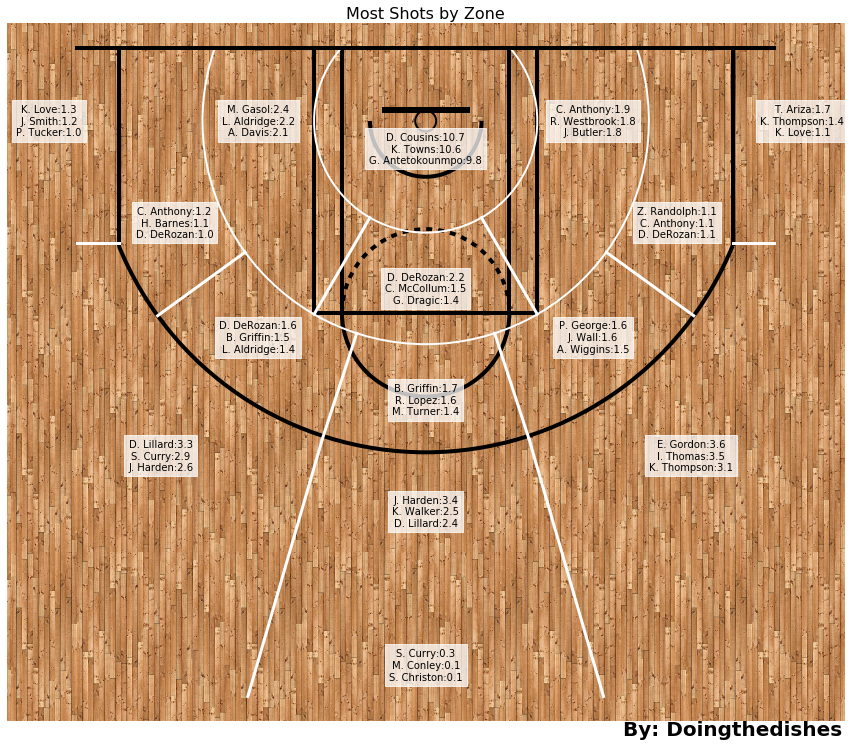

In [6]:
path = os.path.dirname(nba.__file__) # get path of the nba module
floor = misc.imread(path+'\\data\\court.jpg') # load floor template
plt.figure(figsize=(15,12.5),facecolor='white') # set up figure
ax = nba.plot.court(lw=4,outer_lines=False) # plot NBA court - don't include the outer lines
ax.axis('off')
nba.plot.zones(lw=2,color='white',linewidth=3)
eligible = zones_with_GP.loc[:,'GP'].values > 10 # only include players which player more than 10 games
# we are going to use the zone_list to plot information in each zone
for zone in zones_list:
    # calculate shots per game for specific zone and sort from highest to lowest
    shots_PG = (zones_with_GP.loc[eligible,zone].sum(axis=1)/zones_with_GP.loc[eligible,'GP']).sort_values(0,ascending=False)
    name = [] # will be used to store the text we want to print
    # run a loop to find top 3 players 
    for j in range(3):
        # create text
        name.append(shots_PG.index[j][0].split(' ')[0][0]+'. ' + shots_PG.index[j][0].split(' ')[1]+':%0.1f' %shots_PG.values[j])
    nba.plot.text_in_zone('\n'.join(name),zone,color='black',backgroundcolor = 'white',alpha = 1)
plt.title('Most Shots by Zone',fontsize=16)
plt.imshow(floor,extent=[-30,30,-7,43]) # plot floor

## Which players have the highest FG% at every zone? 

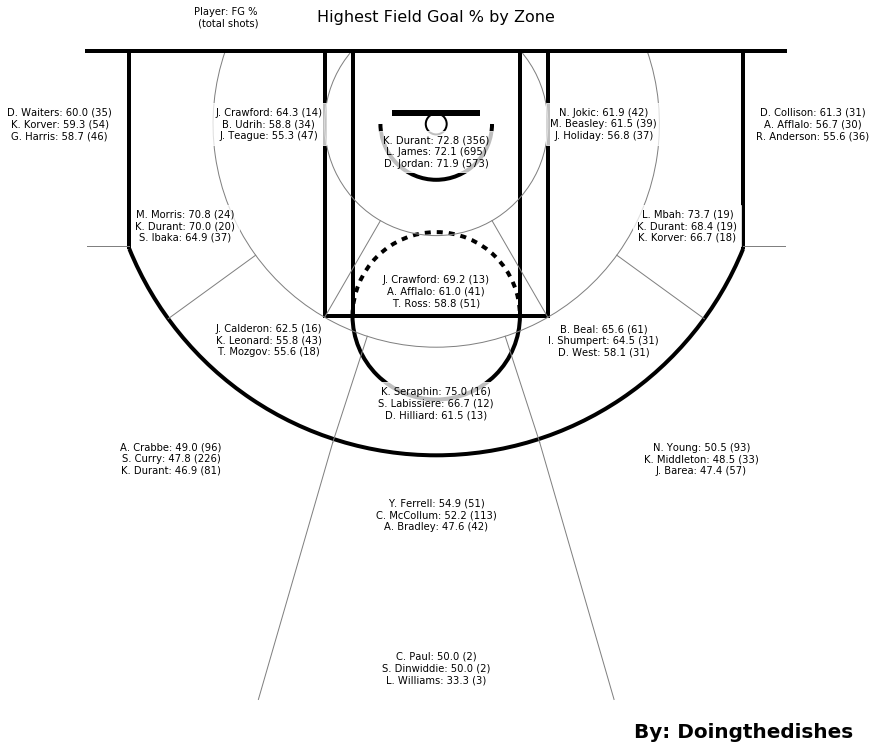

In [7]:
plt.figure(figsize=(15,12.5),facecolor='white')
ax = nba.plot.court(lw=4,outer_lines=False)
ax.axis('off')
nba.plot.zones(color='gray')
eligible = zones_with_GP.loc[:,'GP'].values > 10 
for zone in zones_list:
    # create new dataframe with total shot, shots per game and FG%
    df = pd.concat([zones_with_GP.loc[eligible,zone].sum(axis=1),
                    zones_with_GP.loc[eligible,zone].sum(axis=1)/zones_with_GP.loc[eligible,'GP'],
                    100.0*zones_with_GP.loc[eligible,(zone[0],zone[1],1)]/zones_with_GP.loc[eligible,zone].sum(axis=1)],axis=1)
    df.columns = ['SHOTS','SHOTS_PG','FGP']
    # only include players that have a total of more than 10 shots or are in the top 100 in shots taken (from that zone)
    top100 = df.loc[:,'SHOTS_PG'].sort_values(0,ascending=False)[100]
    if zone != (u'Back Court Shot', u'Back Court(BC)'):
        mask = (df.loc[:,'SHOTS_PG'] >= top100) & (df.loc[:,'SHOTS']>=10)
    else:
        mask = (df.loc[:,'SHOTS']>=2)    
    # sort by FG%
    perc_leaders = df.iloc[mask.values,:].sort_values('FGP',ascending=False)
    name = []
    for j in range(3):
        name.append(perc_leaders.index[j][0].split(' ')[0][0]+'. ' + perc_leaders.index[j][0].split(' ')[1]+': %0.1f (%d)' %(perc_leaders.ix[j,'FGP'],perc_leaders.ix[j,'SHOTS']))
    nba.plot.text_in_zone('\n'.join(name),zone,color='black',backgroundcolor = 'white',alpha = 1)
plt.title('Highest Field Goal % by Zone',fontsize=16)
plt.text(-15,-7,'Player: FG % \n (total shots)',horizontalalignment='center')

I'm going to run the same analysis for the league average and therefore run the groupby without the PLAYER column. I also added another row calculating the FG%.

In [8]:
leagueaverage = shotchart.groupby(['SHOT_ZONE_RANGE','SHOT_ZONE_AREA','SHOT_MADE_FLAG']).size().unstack(fill_value=0).T
leagueaverage = pd.concat([leagueaverage,pd.DataFrame(leagueaverage.loc[1,:]/leagueaverage.sum(),columns=['FGP']).T])
np.round(leagueaverage,2) # round to make display nicer

SHOT_ZONE_RANGE 16-24 ft.                                    \
SHOT_ZONE_AREA  Center(C) Left Side Center(LC) Left Side(L)   
0                  3871.0              4039.00      2675.00   
1                  2574.0              2808.00      1878.00   
FGP                   0.4                 0.41         0.41   

SHOT_ZONE_RANGE                                       24+ ft.  \
SHOT_ZONE_AREA  Right Side Center(RC) Right Side(R) Center(C)   
0                              4559.0       2718.00   8538.00   
1                              3016.0       1770.00   4648.00   
FGP                               0.4          0.39      0.35   

SHOT_ZONE_RANGE                                                          \
SHOT_ZONE_AREA  Left Side Center(LC) Left Side(L) Right Side Center(RC)   
0                           12067.00      4930.00              11810.00   
1                            6513.00      3102.00               6434.00   
FGP                             0.35         0.39                  0.35   

SHOT_ZONE_RANGE                8-16 ft.                             \
SHOT_ZONE_AREA  Right Side(R) Center(C) Left Side(L) Right Side(R)   
0                     4674.00   5327.00       5623.0        5457.0   
1                     2966.00   4052.00       3781.0        3594.0   
FGP                      0.39      0.43          0.4           0.4   

SHOT_ZONE_RANGE Back Court Shot Less Than 8 ft.  
SHOT_ZONE_AREA   Back Court(BC)       Center(C)  
0                        549.00        37099.00  
1                         14.00        48840.00  
FGP                        0.02            0.57

I'm going to plot the FG% and the distribution of shots from each zone for the entire league

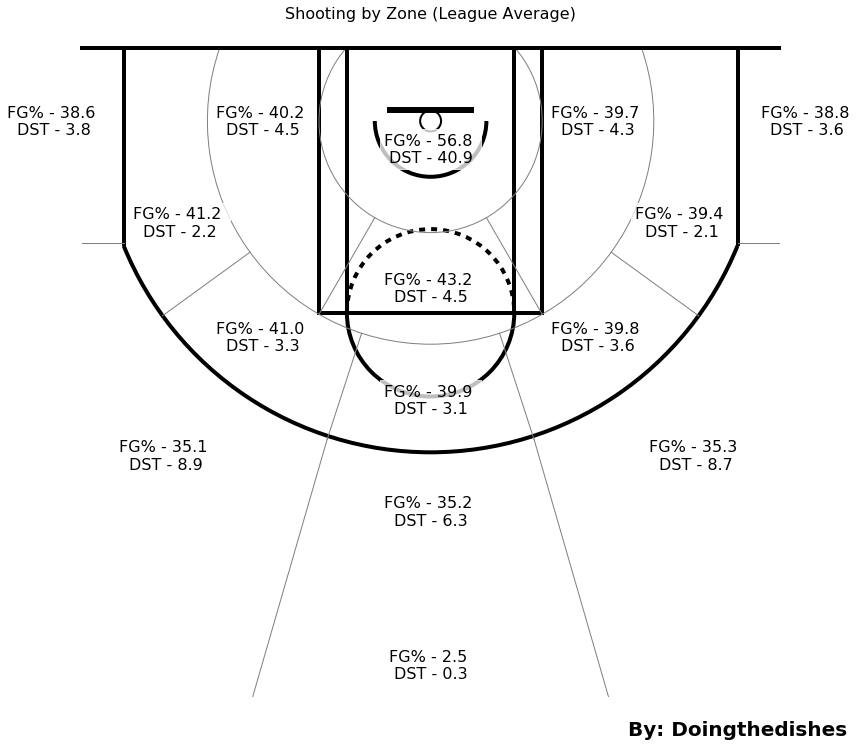

In [9]:
plt.figure(figsize=(15,12.5),facecolor='white')
ax = nba.plot.court(lw=4,outer_lines=False)
ax.axis('off')
nba.plot.zones(color='gray')
total_shots = leagueaverage.loc[0,:].sum()+leagueaverage.loc[1,:].sum()
for zone in zones_list:
    name = 'FG%% - %0.1f \nDST - %0.1f' %(100*leagueaverage.loc['FGP',zone],100*(leagueaverage.loc[0,zone]+leagueaverage.loc[1,zone])/total_shots)
    nba.plot.text_in_zone(name,zone,color='black',backgroundcolor = 'white',alpha = 1,fontsize=16)
plt.title('Shooting by Zone (League Average)',fontsize=16)

### Kevin Durant
I'm going to do a similar analysis as the league average but for a specific player. I choose Kevin Durant but any player would work. The mask can also be done for a team instead of a player (which I will show later)

In [10]:
durant = shotchart.loc[shotchart['PLAYER_NAME']=='Kevin Durant',:] # create a dataframe that only includes Kevin Durant's shots
made = durant['SHOT_MADE_FLAG']==1 # mask for made shots

We can plot all the shots Durant made and missed but it is difficult to extract any information from these plots:

In [2]:
plt.figure(figsize=(15,12.5),facecolor='white')
ax = nba.plot.court(lw=4,outer_lines=True)
ax.axis('off')
nba.plot.zones(color='gray',linewidth=2)
plt.scatter(0.1*durant.loc[made,'LOC_X'],0.1*durant.loc[made,'LOC_Y'],color='blue',alpha=0.75,s=30)
plt.scatter(0.1*durant.loc[~made,'LOC_X'],0.1*durant.loc[~made,'LOC_Y'],color='red',alpha=0.75,marker='x',s30)

NameError: name 'plt' is not defined

I'm going to break down Durant's shoots by zone and compare it to the league average as done on the NBA website (http://stats.nba.com/)

In [12]:
durant_by_zone = durant.groupby(['SHOT_ZONE_RANGE','SHOT_ZONE_AREA','SHOT_MADE_FLAG']).size().unstack(fill_value=0).T
durant_by_zone= pd.concat([durant_by_zone,pd.DataFrame(durant_by_zone.loc[1,:]/durant_by_zone.sum(),columns=['FGP']).T])
np.round(durant_by_zone,2)

SHOT_ZONE_RANGE 16-24 ft.                                    \
SHOT_ZONE_AREA  Center(C) Left Side Center(LC) Left Side(L)   
0                    13.0                16.00          6.0   
1                    13.0                19.00         14.0   
FGP                   0.5                 0.54          0.7   

SHOT_ZONE_RANGE                                       24+ ft.  \
SHOT_ZONE_AREA  Right Side Center(RC) Right Side(R) Center(C)   
0                               28.00          6.00     58.00   
1                               27.00         13.00     27.00   
FGP                              0.49          0.68      0.32   

SHOT_ZONE_RANGE                                                          \
SHOT_ZONE_AREA  Left Side Center(LC) Left Side(L) Right Side Center(RC)   
0                              43.00          6.0                 69.00   
1                              38.00          9.0                 35.00   
FGP                             0.47          0.6                  0.34   

SHOT_ZONE_RANGE                8-16 ft.                             \
SHOT_ZONE_AREA  Right Side(R) Center(C) Left Side(L) Right Side(R)   
0                       17.00     43.00         32.0         39.00   
1                        8.00     45.00         21.0         23.00   
FGP                      0.32      0.51          0.4          0.37   

SHOT_ZONE_RANGE Back Court Shot Less Than 8 ft.  
SHOT_ZONE_AREA   Back Court(BC)       Center(C)  
0                           2.0           97.00  
1                           0.0          259.00  
FGP                         0.0            0.73

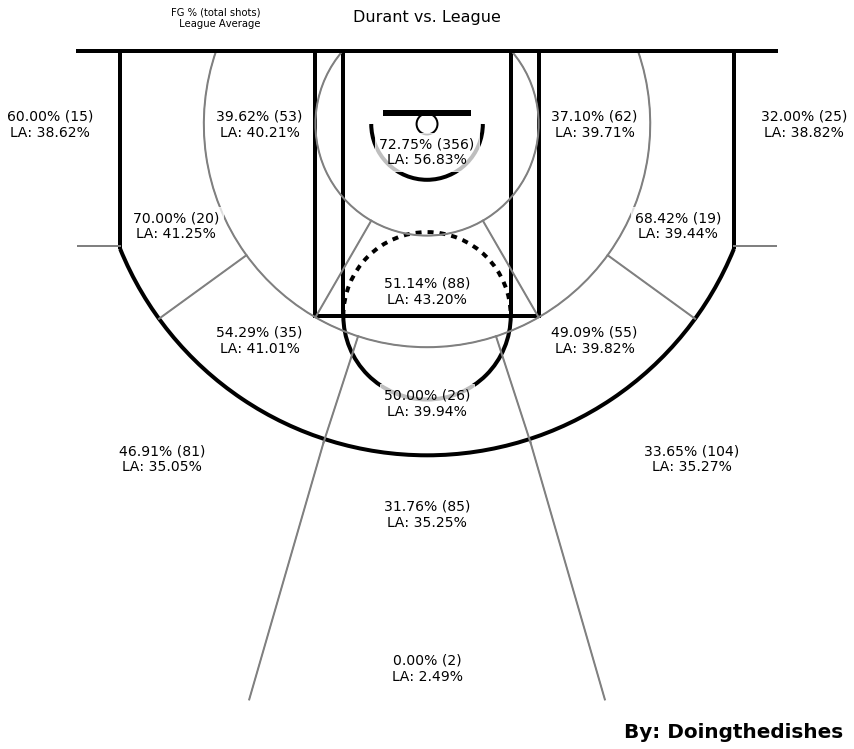

In [13]:
plt.figure(figsize=(15,12.5),facecolor='white')
ax = nba.plot.court(lw=4,outer_lines=False)
ax.axis('off')
nba.plot.zones(color='gray')
nba.plot.zones(color='gray',linewidth=2)
for zone in zones_list:
    name = ['%0.2f%% (%d)' %(100.0*durant_by_zone.loc['FGP',zone],durant_by_zone.loc[0,zone]+durant_by_zone.loc[1,zone]),
            'LA: %0.2f%%' %(100.0*leagueaverage.loc['FGP',zone])]
    nba.plot.text_in_zone('\n'.join(name),zone,color='black',backgroundcolor = 'white',alpha = 1,fontsize=14)
plt.title('Durant vs. League',fontsize=16)
plt.text(-15,-7,'FG % (total shots) \n League Average',horizontalalignment='center')

I'm going to do one exmple with teams instead of players. In order to get the team stats per zone we need too do the same groupby operation as we did for players but this time we will do it with the 'TEAM_NAME' column:

In [14]:
team_by_zone = shotchart.groupby(['SHOT_ZONE_RANGE','SHOT_ZONE_AREA','SHOT_MADE_FLAG','TEAM_NAME']).size().unstack(fill_value=0).T
team_by_zone

SHOT_ZONE_RANGE        16-24 ft.                                              \
SHOT_ZONE_AREA         Center(C)      Left Side Center(LC)      Left Side(L)   
SHOT_MADE_FLAG                 0    1                    0    1            0   
TEAM_NAME                                                                      
Atlanta Hawks                138   94                  125   94           89   
Boston Celtics               124   74                   86   72           59   
Brooklyn Nets                 61   47                   51   34           39   
Charlotte Hornets            145   82                  114   89           94   
Chicago Bulls                206  133                  144   84          127   
Cleveland Cavaliers           75   45                  108   68           80   
Dallas Mavericks             160  124                  183  105          110   
Denver Nuggets               129   72                   98   62           77   
Detroit Pistons              143   99                  153  117          104   
Golden State Warriors        101   68                  108   99           64   
Houston Rockets               59   37                   39   26           34   
Indiana Pacers               191  154                  156  120          131   
LA Clippers                  206  140                  170  146           69   
Los Angeles Lakers           103   75                  145   96           77   
Memphis Grizzlies            127   55                  143  111           93   
Miami Heat                    89   64                  166  102           89   
Milwaukee Bucks              100   61                  101   73          103   
Minnesota Timberwolves       152   98                  192  126          128   
New Orleans Pelicans         128   78                  173  101          126   
New York Knicks              130   95                  165  127          126   
Oklahoma City Thunder         99   70                  124   76           75   
Orlando Magic                122   83                  174   97           81   
Philadelphia 76ers           106   52                   83   46           60   
Phoenix Suns                 155   91                  161  111          113   
Portland Trail Blazers       128   89                  165  125           90   
Sacramento Kings             145  103                  130  100           88   
San Antonio Spurs            156  127                  171  137          114   
Toronto Raptors              135   99                  147   97           87   
Utah Jazz                    106   64                   98   62           78   
Washington Wizards           152  101                  166  105           70   

SHOT_ZONE_RANGE                                                           \
SHOT_ZONE_AREA              Right Side Center(RC)      Right Side(R)       
SHOT_MADE_FLAG            1                     0    1             0   1   
TEAM_NAME                                                                  
Atlanta Hawks            60                   142  109           103  92   
Boston Celtics           35                   124   98            67  36   
Brooklyn Nets            22                    89   49            64  31   
Charlotte Hornets        58                   186  105           119  70   
Chicago Bulls            76                   183  112           136  77   
Cleveland Cavaliers      75                   110   82            84  70   
Dallas Mavericks         88                   194  115           133  67   
Denver Nuggets           48                    97   91            69  36   
Detroit Pistons          96                   140   79           128  84   
Golden State Warriors    79                   165  126            53  60   
Houston Rockets          22                    49   34            45  16   
Indiana Pacers           85                   201  131           107  74   
LA Clippers              57                   200  166         

## Which teams have the highest FG% at every zone?

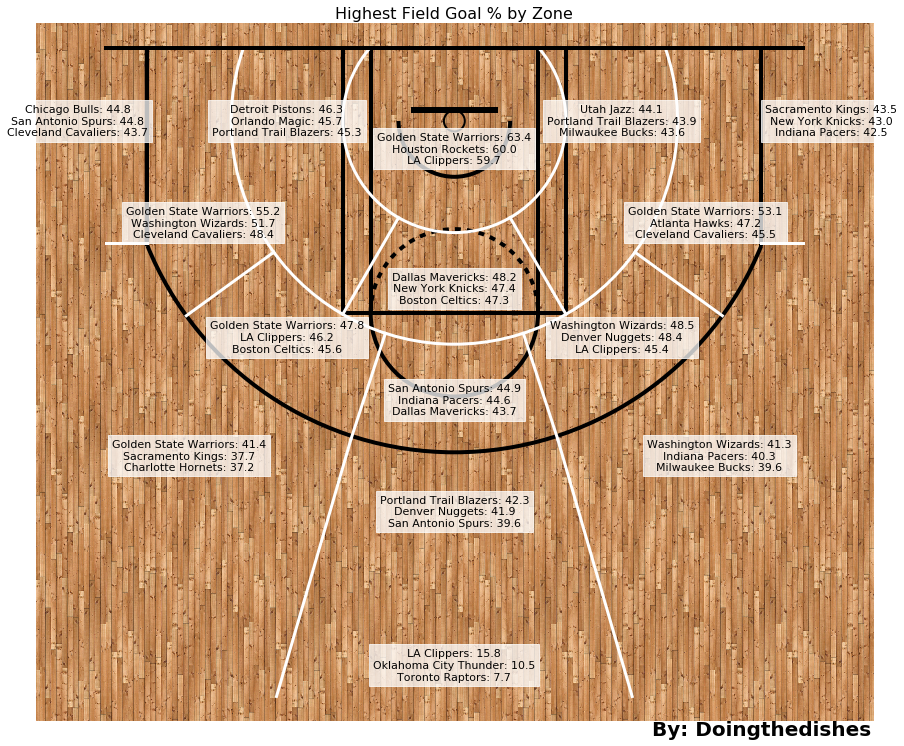

In [15]:
plt.figure(figsize=(15,12.5),facecolor='white')
ax = nba.plot.court(lw=4,outer_lines=False)
ax.axis('off')
nba.plot.zones(color='white',linewidth=3) 
for zone in zones_list:
    # create series and sort by FG%
    perc_leaders = (100.0*team_by_zone.loc[:,(zone[0],zone[1],1)]/team_by_zone.loc[:,zone].sum(axis=1)).sort_values(ascending=False)
    name = []
    for j in range(3):
        name.append(perc_leaders.index[j]+': %0.1f' %(perc_leaders.ix[j,'FGP']))
    nba.plot.text_in_zone('\n'.join(name),zone,color='black',backgroundcolor = 'white',fontsize=11)
plt.title('Highest Field Goal % by Zone',fontsize=16)
plt.imshow(floor,extent=[-30,30,-7,43])

As we have seen in above, about 40.9% of shots in the NBA are from less than 8 feet and 31.6% from 3s . Let's try and compare the correlation between team's winning % and their shooting % from under the basket, three point FG% and FG%: 

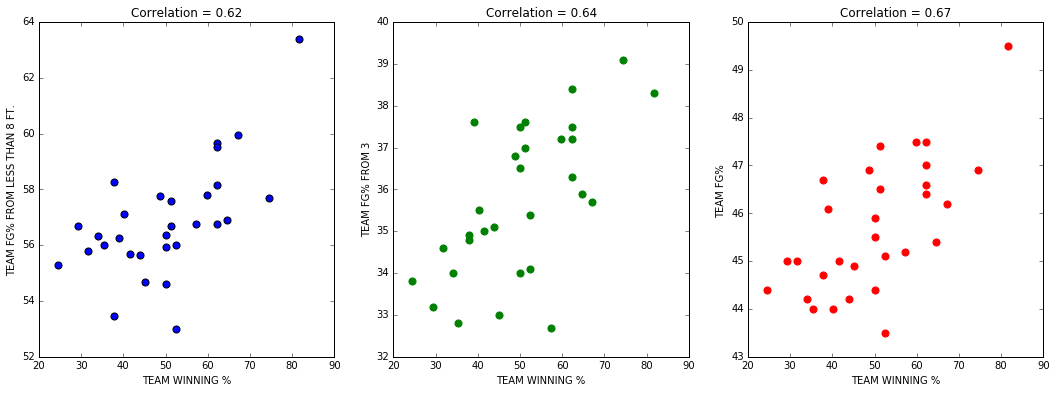

In [16]:
zone = (u'Less Than 8 ft.', u'Center(C)')
perc_leaders = (100.0*team_by_zone.loc[:,(zone[0],zone[1],1)]/team_by_zone.loc[:,zone].sum(axis=1)).sort_values(ascending=False)
team_stats = nba.team.stats(season='2016-17').set_index('TEAM_NAME') # load team stats from NBA API
team_stats_with_zone = team_stats.merge(perc_leaders.to_frame(),left_index=True,right_index=True) # merge team stats with % from less than 8 ft.
plt.figure(figsize=(18,6))
plt.subplot(1,3,1)
plt.scatter(100.0*team_stats_with_zone['W_PCT'],team_stats_with_zone[0],s=50)
plt.xlabel(r'TEAM WINNING %')
plt.ylabel(r'TEAM FG% FROM LESS THAN 8 FT.')
plt.title('Correlation = %.2f' %pearsonr(100.0*team_stats_with_zone['W_PCT'],team_stats_with_zone[0])[0])
plt.subplot(1,3,2)
plt.scatter(100.0*team_stats_with_zone['W_PCT'],100.0*team_stats_with_zone['FG3_PCT'],s=50,color='green')
plt.title('Correlation = %.2f' %pearsonr(100.0*team_stats_with_zone['W_PCT'],team_stats_with_zone['FG3_PCT'])[0])
plt.xlabel(r'TEAM WINNING %')
plt.ylabel(r'TEAM FG% FROM 3')
plt.subplot(1,3,3)
plt.scatter(100.0*team_stats_with_zone['W_PCT'],100.0*team_stats_with_zone['FG_PCT'],s=50,color='red')
plt.title('Correlation = %.2f' %pearsonr(100.0*team_stats_with_zone['W_PCT'],team_stats_with_zone['FG_PCT'])[0])
plt.xlabel(r'TEAM WINNING %')
plt.ylabel(r'TEAM FG% ')

## References:
1. Court plotting function was modified from: http://savvastjortjoglou.com/
2. Accessing the NBA APi - http://www.gregreda.com/2015/02/15/web-scraping-finding-the-api/
3. Another NBA package for python - https://pypi.python.org/pypi/nbastats/1.0.0

In [17]:
print(pd.__version__)
print(np.__version__)
print (sys.version)

0.19.1
1.12.0
2.7.11 |Anaconda custom (64-bit)| (default, Feb 16 2016, 09:58:36) [MSC v.1500 64 bit (AMD64)]
